In [2]:
### 
#from agents import Agent, Runner
from IPython.display import display, Markdown
import os
from openai import OpenAI
from bs4 import BeautifulSoup
from dotenv import load_dotenv
import os
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats
from pydeseq2.default_inference import DefaultInference
import os
import time
import json
import re
import requests
import pandas as pd
from typing import TypedDict, List, Dict, Any
from bs4 import BeautifulSoup
from geofetch import Geofetcher
from openai import OpenAI
import anthropic
from langgraph.graph import StateGraph
from langchain_core.runnables import RunnableLambda
# load environment variables from .env file
load_dotenv()
# get the environment variable
#client = OpenAI(api_key=os.environ.get("OPENAI_API_KEY"))
client = anthropic.Anthropic(api_key=os.environ.get("ANTHROPIC_API_KEY"))
#client = OpenAI()

In [4]:
# ----------------------------------------
# Agent state schema
# ----------------------------------------

class AgentState(TypedDict):
    query_gene: str
    pathway_info: Dict[str, Any]
    metadata: Dict[str, Any]
    gse_list: list
    research_plan: str
    selected_gse: str  # ⬅️ now added
    selected_gses: List[str]  # ✅ new field for multiple GSEs
    deg_results: Dict[str, str]  # ✅ map GSE → output CSV path
# Utility to extract all GSE IDs from plan
def extract_all_gse_ids(plan_text: str) -> List[str]:
    return re.findall(r"GSE\d{5,}", plan_text)

def extract_gse_from_research_plan(state: AgentState) -> AgentState:
    plan = state.get("research_plan", "")
    match = re.search(r"GSE\d{5,}", plan)
    if match:
        selected_gse = match.group(0)
        print(f"🔍 Extracted GSE ID: {selected_gse}")
        return {**state, "selected_gse": selected_gse}
    else:
        print("⚠️ No GSE ID found in research plan.")
        return state

# LangGraph node: Extract GSEs from research plan and update state
def extract_gse_list_from_plan(state: AgentState) -> AgentState:
    plan = state.get("research_plan", "")
    gse_ids = extract_all_gse_ids(plan)
    print(f"🔍 Extracted GSE IDs: {gse_ids}")
    return {**state, "selected_gses": gse_ids}

# DEG analysis node: run DESeq2 for multiple studies
def run_deg_for_multiple_gses(state: AgentState) -> AgentState:
    gse_ids = state.get("selected_gses", [])
    if not gse_ids:
        raise ValueError("No selected GSEs found.")

    deg_paths = {}

    for gse_id in gse_ids:
        try:
            print(f"\n🧬 Running DESeq2 for: {gse_id}")
            count_path = f"rna_seq_analysis/{gse_id}_raw_counts.csv"
            if not os.path.exists(count_path):
                print(f"❌ Missing count file for {gse_id}")
                continue

            counts_df = pd.read_csv(count_path, index_col=0) + 1

            meta_df = pd.read_csv("geofetch_metadata/combined_metadata.csv")
            meta_gse = meta_df[meta_df["gse"] == gse_id].copy()

            meta_gse["condition"] = meta_gse["sample_title"].str.contains("PGE2", case=False).map({True: "treated", False: "control"})
            metadata_df = meta_gse.set_index("sample_geo_accession")[["condition"]]

            valid_samples = metadata_df.index.intersection(counts_df.columns)
            counts_df = counts_df[valid_samples]
            metadata_df = metadata_df.loc[valid_samples]

            if counts_df.empty or metadata_df.empty:
                print(f"⚠️ Skipping {gse_id}: no matching samples")
                continue

            inference = DefaultInference(n_cpus=1)
            dds = DeseqDataSet(
                counts=counts_df.T,
                metadata=metadata_df,
                design_factors="condition",
                refit_cooks=True,
                inference=inference,
            )

            dds.deseq2()
            ds = DeseqStats(dds, contrast=["condition", "treated", "control"], inference=inference)
            ds.summary()

            output_csv = f"rna_seq_analysis/{gse_id}_deseq2_results.csv"
            ds.results_df.to_csv(output_csv, index=False)
            print(f"✅ Saved DEG results for {gse_id}: {output_csv}")
            deg_paths[gse_id] = output_csv

        except Exception as e:
            print(f"❌ Error running DESeq2 for {gse_id}: {e}")

    return {**state, "deg_results": deg_paths}

def run_deg_for_multiple_gses_debug(state: AgentState) -> AgentState:
    gse_ids = state.get("selected_gses", [])
    if not gse_ids:
        print("⚠️ No selected GSEs found.")
        return state

    deg_paths = {}

    for gse_id in gse_ids:
        try:
            print(f"\n🧬 Running DESeq2 for: {gse_id}")
            count_path = f"rna_seq_analysis/{gse_id}_raw_counts.csv"
            if not os.path.exists(count_path):
                print(f"❌ Missing count file for {gse_id}")
                continue

            counts_df = pd.read_csv(count_path, index_col=0) + 1
            print(f"✅ Loaded count matrix: {counts_df.shape}")

            meta_df = pd.read_csv("geofetch_metadata/combined_metadata.csv")
            meta_gse = meta_df[meta_df["gse"] == gse_id].copy()
            print(f"✅ Loaded metadata: {meta_gse.shape}")

            meta_gse["condition"] = meta_gse["sample_title"].str.contains("PGE2", case=False).map({True: "treated", False: "control"})
            metadata_df = meta_gse.set_index("sample_geo_accession")[["condition"]]

            print(f"🔍 Metadata index (GSM): {list(metadata_df.index[:5])}")
            print(f"🔍 Count matrix columns (samples): {list(counts_df.columns[:5])}")

            valid_samples = metadata_df.index.intersection(counts_df.columns)
            print(f"🔗 Intersected samples: {list(valid_samples)}")

            counts_df = counts_df[valid_samples]
            metadata_df = metadata_df.loc[valid_samples]

            if counts_df.empty or metadata_df.empty:
                print(f"⚠️ Skipping {gse_id}: no matching samples")
                continue

            inference = DefaultInference(n_cpus=1)
            dds = DeseqDataSet(
                counts=counts_df.T,
                metadata=metadata_df,
                design_factors="condition",
                refit_cooks=True,
                inference=inference,
            )

            dds.deseq2()
            ds = DeseqStats(dds, contrast=["condition", "treated", "control"], inference=inference)
            ds.summary()

            output_csv = f"rna_seq_analysis/{gse_id}_deseq2_results.csv"
            ds.results_df.to_csv(output_csv, index=False)
            print(f"✅ Saved DEG results for {gse_id}: {output_csv}")
            deg_paths[gse_id] = output_csv

        except Exception as e:
            print(f"❌ Error running DESeq2 for {gse_id}: {e}")

    return {**state, "deg_results": deg_paths}


# ----------------------------------------
# Utility functions (LLM + GEO search)
# ----------------------------------------

client = OpenAI()

def extract_json_block(text):
    match = re.search(r"```json\s*(\{.*?\})\s*```", text, re.DOTALL)
    if match:
        return json.loads(match.group(1))
    else:
        return json.loads(text)


def extract_json_block(text: str) -> dict:
    """
    Extract and parse the first JSON block from LLM output, with fallback and error reporting.
    """
    import json
    import re

    try:
        match = re.search(r"```json\s*({.*?})\s*```", text, re.DOTALL)
        if match:
            return json.loads(match.group(1))
        return json.loads(text)  # fallback if no block match
    except json.JSONDecodeError as e:
        print("⚠️ JSON decode error:", e)
        print("🔍 Raw content:\n", text[:1000])  # preview
        raise




def generate_pathway_info(query_gene, model="gpt-4o-mini", temperature=0.3):
    prompt = f"""
You are a biomedical assistant.

Given the gene {query_gene}, return:
1. Key gene symbols in the same biological pathway.
2. Drugs or compounds that inhibit this pathway or {query_gene}'s activity.
3. The disease areas or biological processes this pathway is involved in.

Provide answers in JSON format with keys: "genes", "drugs", "pathways"
    """
    completion = client.chat.completions.create(
        model=model,
        temperature=temperature,
        messages=[{"role": "user", "content": prompt}]
    )
    content = completion.choices[0].message.content
    return extract_json_block(content)



def scrape_organism_from_geo_html(geo_accession):
    url = f"https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc={geo_accession}"
    try:
        response = requests.get(url)
        response.raise_for_status()
        soup = BeautifulSoup(response.text, "html.parser")
        organism_row = soup.find("td", string="Organism")
        if organism_row and organism_row.find_next_sibling("td"):
            return organism_row.find_next_sibling("td").text.strip()
    except Exception as e:
        print(f"⚠️ Failed to scrape organism for {geo_accession}: {e}")
    return "Unknown"

def search_geo_datasets(keyword, retmax=10):
    base_url = "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi"
    params = {
        "db": "gds",
        "term": keyword,
        "retmode": "json",
        "retmax": retmax
    }
    response = requests.get(base_url, params=params)
    response.raise_for_status()
    return response.json().get("esearchresult", {}).get("idlist", [])

def fetch_gse_accessions(id_list):
    if not id_list:
        return {}
    base_url = "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi"
    params = {
        "db": "gds",
        "id": ",".join(id_list),
        "retmode": "json"
    }
    response = requests.get(base_url, params=params)
    response.raise_for_status()
    summaries = response.json().get("result", {})
    summaries.pop("uids", None)
    gse_dict = {}
    for uid, info in summaries.items():
        accession = info.get("accession")
        title = info.get("title")
        link = f"https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc={accession}"
        organism = scrape_organism_from_geo_html(accession)
        gse_dict[accession] = {
            "title": title,
            "organism": organism,
            "link": link
        }
    return gse_dict

def search_geo_items(item_list, label="gene", max_results=5):
    results = {}
    for item in item_list:
        query = f"{item} AND rna-seq"
        print(f"🔍 Searching GEO for {label}: {item}")
        ids = search_geo_datasets(query, retmax=max_results)
        datasets = fetch_gse_accessions(ids)
        results[item] = datasets
        time.sleep(0.3)
    return results

def get_geofetch_projects(gse_list, metadata_folder="geofetch_metadata"):
    geof = Geofetcher(
        processed=True,
        acc_anno=True,
        discard_soft=True,
        metadata_folder=metadata_folder
    )
    projects = {}
    for gse in gse_list:
        try:
            print(f"📥 Fetching metadata for {gse}")
            result = geof.get_projects(gse)
            projects.update(result)
        except Exception as e:
            print(f"❌ Failed to fetch {gse}: {e}")
    return projects

import subprocess
def download_processed_files_via_cli(gse_list, output_dir="geofetch_metadata", overwrite=False):
    for gse in gse_list:
        gse_path = os.path.join(output_dir, gse)
        if os.path.exists(gse_path) and not overwrite:
            print(f"✅ {gse}: already exists at {gse_path}, skipping.")
            continue
        try:
            subprocess.run(
                ["geofetch", "-i", gse, "--processed", "-m", output_dir],
                check=True
            )
            print(f"✅ Finished downloading for {gse}")
        except subprocess.CalledProcessError as e:
            print(f"❌ geofetch failed for {gse}: {e}")

def save_combined_metadata_csv_from_state(state: Dict, csv_path: str = "geofetch_metadata/combined_metadata.csv") -> pd.DataFrame:
    metadata = state.get("metadata", {})
    if not metadata:
        raise ValueError("No metadata found in the agent state.")

    all_dfs = []
    for gse, project in metadata.items():
        try:
            df = project.sample_table.copy()
            df["source_gse"] = gse
            all_dfs.append(df)
        except Exception as e:
            print(f"⚠️ Failed to extract sample_table from {gse}: {e}")

    if not all_dfs:
        raise ValueError("No sample tables to save.")

    combined_df = pd.concat(all_dfs, ignore_index=True)
    os.makedirs(os.path.dirname(csv_path), exist_ok=True)
    combined_df.to_csv(csv_path, index=False)
    print(f"✅ Combined metadata saved to: {os.path.abspath(csv_path)}")
    return combined_df

# ----------------------------------------
# Agent 1: Ingestor node
# ----------------------------------------

def ingest_and_prepare(state: dict) -> dict:
    query_gene = state["query_gene"]
    pathway_info = generate_pathway_info(query_gene)
    gene_list = pathway_info.get("genes", [])
    drug_list = pathway_info.get("drugs", [])

    gene_results = search_geo_items(gene_list, label="gene")
    drug_results = search_geo_items(drug_list, label="drug")

    all_gse = set()
    for r in [gene_results, drug_results]:
        for v in r.values():
            all_gse.update(v.keys())
    all_gse = list(all_gse)

    metadata = get_geofetch_projects(all_gse, metadata_folder="geofetch_metadata")
    download_processed_files_via_cli(all_gse, output_dir="geofetch_metadata")

    try:
        save_combined_metadata_csv_from_state({"metadata": metadata})
    except Exception as e:
        print(f"⚠️ Failed to save metadata CSV: {e}")

    return {
        "query_gene": query_gene,
        "pathway_info": pathway_info,
        "metadata": metadata,
        "gse_list": all_gse
    }



import subprocess
import tarfile
import gzip
import shutil
import requests
from bs4 import BeautifulSoup
from urllib.parse import urljoin, urlparse, parse_qs, unquote
from pathlib import Path

# ----------------------------------------
# Utility: Scrape GEO supplementary HTTP links
# ----------------------------------------
def scrape_geo_supplementary_downloads(gse_id: str):
    base_url = "https://www.ncbi.nlm.nih.gov"
    url = f"{base_url}/geo/query/acc.cgi?acc={gse_id}"

    try:
        response = requests.get(url)
        response.raise_for_status()
        soup = BeautifulSoup(response.text, "html.parser")
        tables = soup.find_all("table")

        for table in tables:
            if "Supplementary file" in table.get_text():
                rows = table.find_all("tr")
                downloadable_files = []

                for row in rows[1:]:
                    cols = row.find_all("td")
                    if len(cols) >= 3:
                        file_name = cols[0].text.strip()
                        download_cell = cols[2]
                        links = download_cell.find_all("a", href=True)

                        for a_tag in links:
                            href = a_tag["href"]
                            if href.startswith("/geo/download"):
                                full_http_link = urljoin(base_url, href)
                                downloadable_files.append((file_name, full_http_link))
                                break
                return downloadable_files
        return []
    except Exception as e:
        print(f"❌ Failed to scrape {gse_id}: {e}")
        return []

# ----------------------------------------
# Embedded in Ingestor Agent
# ----------------------------------------
def ingest_and_prepare(state: dict) -> dict:
    query_gene = state["query_gene"]
    pathway_info = generate_pathway_info(query_gene)
    gene_list = pathway_info.get("genes", [])
    drug_list = pathway_info.get("drugs", [])

    gene_results = search_geo_items(gene_list, label="gene")
    drug_results = search_geo_items(drug_list, label="drug")

    all_gse = set()
    for r in [gene_results, drug_results]:
        for v in r.values():
            all_gse.update(v.keys())
    all_gse = list(all_gse)

    # ----------------------------------------
    # Download each GSE using embedded logic
    # ----------------------------------------
    base_dir = Path("rna_seq_analysis")
    for gse_id in all_gse:
        download_dir = base_dir / gse_id

        if download_dir.exists() and any(download_dir.iterdir()):
            print(f"📁 Skipping {gse_id}: folder already exists.")
            continue

        download_dir.mkdir(parents=True, exist_ok=True)
        files = scrape_geo_supplementary_downloads(gse_id)
        if not files:
            print(f"⚠️ No supplementary files found for {gse_id}")
            continue

        file_name, url = files[0]
        if not file_name:
            parsed = urlparse(url)
            qs = parse_qs(parsed.query)
            file_name = unquote(qs.get("file", ["unnamed_file"])[0])

        file_path = download_dir / file_name
        print(f"📥 Downloading {file_name} → {file_path.as_posix()}")

        try:
            subprocess.run(["curl", "-L", "-o", file_path.as_posix(), url], check=True)
        except subprocess.CalledProcessError as e:
            print(f"❌ Download failed for {gse_id}: {e}")
            continue

        try:
            if tarfile.is_tarfile(file_path):
                print("🗂️ Extracting TAR...")
                with tarfile.open(file_path, "r:*") as tar:
                    tar.extractall(path=download_dir)
            elif file_path.suffix == ".gz" and not file_path.name.endswith(".tar.gz"):
                unzipped_path = file_path.with_suffix("")
                print("🗂️ Extracting GZ...")
                with gzip.open(file_path, 'rb') as f_in:
                    with open(unzipped_path, 'wb') as f_out:
                        shutil.copyfileobj(f_in, f_out)
        except Exception as e:
            print(f"⚠️ Extraction failed for {gse_id}: {e}")
            continue

    # ----------------------------------------
    # Continue with metadata and return
    # ----------------------------------------
    metadata = get_geofetch_projects(all_gse, metadata_folder="geofetch_metadata")
    download_processed_files_via_cli(all_gse, output_dir="geofetch_metadata")

    try:
        save_combined_metadata_csv_from_state({"metadata": metadata})
    except Exception as e:
        print(f"⚠️ Failed to save metadata CSV: {e}")

    return {
        "query_gene": query_gene,
        "pathway_info": pathway_info,
        "metadata": metadata,
        "gse_list": all_gse
    }

# ----------------------------------------
# Agent 2: Analyst node
# ----------------------------------------

def analyze_metadata_and_plan(state: AgentState) -> AgentState:
    metadata = state["metadata"]
    drug_list = state["pathway_info"].get("drugs", [])
    query_gene = state["query_gene"]
    selected = []

    for gse, project in metadata.items():
        df = project.sample_table
        if "processed_file_ftp" in df.columns and df["processed_file_ftp"].notna().any():
            if any(drug.lower() in df.to_string().lower() for drug in drug_list):
                selected.append((gse, df.shape[0]))

    plan = f"🧬 Research Plan for {query_gene} and drugs {drug_list}:\n"
    if not selected:
        plan += "No relevant processed datasets were found.\n"
    else:
        plan += f"{len(selected)} datasets selected:\n"
        for gse, n in selected:
            plan += f"  - {gse} ({n} samples)\n"
        plan += "\nNext: perform differential expression and gene signature clustering."

    return {**state, "research_plan": plan}


def analyze_metadata_and_plan(state: AgentState) -> AgentState:
    import pandas as pd
    import os

    csv_path = "geofetch_metadata/combined_metadata.csv"
    if not os.path.exists(csv_path):
        raise FileNotFoundError(f"❌ Metadata CSV not found at {csv_path}")

    df = pd.read_csv(csv_path)

    # Ensure required columns exist
    required_columns = {"sample_name", "sample_source_name_ch1", "sample_title"}
    if not required_columns.issubset(df.columns):
        raise ValueError(f"❌ Metadata CSV must include columns: {required_columns}")

    # Take first 50 rows for LLM context
    selected_df = df[list(required_columns)].fillna("").head(50)
    table_preview = selected_df.to_markdown(index=False)

    query_gene = state["query_gene"]
    drug_list = state["pathway_info"].get("drugs", [])
    selected_df = df[["sample_name", "sample_source_name_ch1", "sample_title"]].fillna("").head(50)
    table_preview = selected_df.to_markdown(index=False)
    print("🧪 Table preview sent to LLM:\n", table_preview)  # ✅ Add this line

    # Build LLM prompt
    prompt = f"""
You are a biomedical research assistant.

The target gene is **{query_gene}**, and the related drugs of interest are: {', '.join(drug_list)}.

Below is a preview of sample metadata (first 50 rows) from multiple GEO studies. Each row includes:
- sample name
- sample source (cell line, tissue)
- sample title (may indicate treatment or condition)

Your task:
1. Identify which studies include drug-treated samples.
2. Identify the control groups if available.
3. Determine the sample types (e.g., cell lines or tissues).
4. Recommend studies and sample comparisons suitable for differential gene expression and drug-response signature analysis.

Respond with:
- GSE or study names (if known)
- The experimental comparison design
- Why the dataset is suitable (or not)
- Bullet points summarizing each recommended comparison

Sample Metadata Table:

"""

    # Call LLM
    response = client.chat.completions.create(
        model="gpt-4o-mini",
        temperature=0.3,
        messages=[{"role": "user", "content": prompt}]
    )

    research_plan = response.choices[0].message.content.strip()

    return {
        **state,
        "research_plan": research_plan
    }

###
def analyze_metadata_and_plan(state: AgentState) -> AgentState:
    import pandas as pd
    import os

    csv_path = "geofetch_metadata/combined_metadata.csv"
    if not os.path.exists(csv_path):
        raise FileNotFoundError(f"❌ Metadata CSV not found at {csv_path}")

    df = pd.read_csv(csv_path)

    # Ensure required columns are available
    required_cols = ["gse", "sample_name", "sample_title", "sample_source_name_ch1", "sample_geo_accession"]
    if not all(col in df.columns for col in required_cols):
        raise ValueError(f"❌ Metadata CSV must contain the following columns: {required_cols}")

    # Clean and preview first 30 rows
    preview_df = df[required_cols].fillna("").head(30)
    preview_text = preview_df.to_string(index=False)

    query_gene = state["query_gene"]
    drug_list = state["pathway_info"].get("drugs", [])

    prompt = f"""
You are a biomedical research assistant.

The target gene is **{query_gene}** and the related drugs of interest are: {', '.join(drug_list)}.

Below is a preview of sample metadata from several GEO datasets.
Each row includes:
- GSE accession
- Sample name
- Sample title (may contain treatment or control info)
- Sample source (cell type or tissue)
- Sample GEO accession

Sample Metadata Table:
{preview_text}

Based on the sample names, titles, and sources:
1. Which GSE studies contain drug-treated samples and matching control groups?
2. What cell types or tissues are used?
3. Which treatments are applied? What are the controls?
4. Recommend GSEs and sample pairs suitable for differential gene expression to identify drug-response gene signatures.

Be specific, refer to GSE and sample names where possible, and explain why you recommend them.
"""

    # Call OpenAI LLM
    response = client.chat.completions.create(
        model="gpt-4o-mini",
        temperature=0.3,
        messages=[{"role": "user", "content": prompt}]
    )

    research_plan = response.choices[0].message.content.strip()

    return {
        **state,
        "research_plan": research_plan
    }

# ----------------------------------------
# LangGraph pipeline
# ----------------------------------------

#workflow = StateGraph(state_schema=AgentState)
#workflow.add_node("Ingestor", RunnableLambda(ingest_and_prepare))
#workflow.add_node("Analyst", RunnableLambda(analyze_metadata_and_plan))
#workflow.add_node("GSESelector", RunnableLambda(extract_gse_from_research_plan))
#workflow.set_entry_point("Ingestor")
#workflow.add_edge("Ingestor", "Analyst")
#workflow.set_finish_point("Analyst")
#workflow.add_edge("Analyst", "GSESelector")
# Set finish point to "GSESelector" if no DEGRunner yet
#workflow.set_finish_point("GSESelector")
#graph = workflow.compile()

#############
# Build the pipeline
workflow = StateGraph(state_schema=AgentState)

# Add nodes
workflow.add_node("Ingestor", RunnableLambda(ingest_and_prepare))
workflow.add_node("Analyst", RunnableLambda(analyze_metadata_and_plan))
workflow.add_node("GSEListExtractor", RunnableLambda(extract_gse_list_from_plan))
#workflow.add_node("DEGRunner", RunnableLambda(run_deg_for_multiple_gses))
workflow.add_node("DEGRunner", RunnableLambda(run_deg_for_multiple_gses_debug))
# Connect nodes
workflow.set_entry_point("Ingestor")
workflow.add_edge("Ingestor", "Analyst")
workflow.add_edge("Analyst", "GSEListExtractor")
workflow.add_edge("GSEListExtractor", "DEGRunner")

# Final output node
workflow.set_finish_point("DEGRunner")

# Compile the graph
graph = workflow.compile()


# ----------------------------------------
# Invoke the graph
# ----------------------------------------



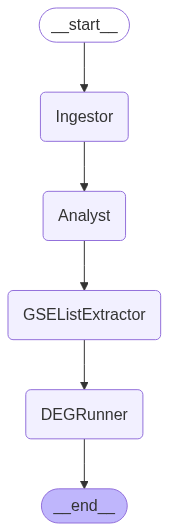

In [5]:
from IPython.display import Image, display
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass


In [6]:
if __name__ == "__main__":
    result = graph.invoke({"query_gene": "IL13"})
    print("\n📋 Final Research Plan:")
    print(result["research_plan"])
    print(result.get("research_plan", ""))
    print("\n📂 DEG Results:")
    results = result.get("deg_results", {})
    if isinstance(results, dict):
        for gse, path in results.items():
            print(f" - {gse}: {path}")
    else:
        print("❌ DEG results not found or not formatted correctly.")

🔍 Searching GEO for gene: IL4
🔍 Searching GEO for gene: STAT6
🔍 Searching GEO for gene: GATA3
🔍 Searching GEO for gene: IL5
🔍 Searching GEO for gene: IL25
🔍 Searching GEO for gene: IL9
🔍 Searching GEO for gene: TNF
🔍 Searching GEO for gene: CCL11
🔍 Searching GEO for drug: Dupilumab
🔍 Searching GEO for drug: Lebrikizumab
🔍 Searching GEO for drug: Tralokinumab
🔍 Searching GEO for drug: Mepolizumab
🔍 Searching GEO for drug: Reslizumab
🔍 Searching GEO for drug: Benralizumab
📥 Downloading GSE296778_Mouse_ear_pinnae_Normalized_count.txt.gz → rna_seq_analysis/GSE296778/GSE296778_Mouse_ear_pinnae_Normalized_count.txt.gz
🗂️ Extracting GZ...
📥 Downloading GSE244202_DESeq2_IL25KO3dirr_new_umi_counts_20230314_183611.xlsx → rna_seq_analysis/GSE244202/GSE244202_DESeq2_IL25KO3dirr_new_umi_counts_20230314_183611.xlsx
📥 Downloading GSE272100_RAFLS_processed_data_file.txt.gz → rna_seq_analysis/GSE272100/GSE272100_RAFLS_processed_data_file.txt.gz
🗂️ Extracting GZ...
📥 Downloading GSE288205_4_genes_fpkm_e

[INFO] [18:49:11] Metadata folder: C:\Users\difen\release\geofetch_metadata\project_name
[INFO] [18:49:11] Trying GSE296778 (not a file) as accession...
[INFO] [18:49:11] Processing accession 1 of 1: 'GSE296778'
[INFO] [18:49:11] Trying GSE296778 (not a file) as accession...
[INFO] [18:49:11] Skipped 0 accessions. Starting now.
[INFO] [18:49:11] Processing accession 1 of 1: 'GSE296778'


🗂️ Extracting GZ...
📥 Fetching metadata for GSE296778


[INFO] [18:49:13] Total number of processed SERIES files found is: 1
[INFO] [18:49:13] Expanding metadata list...
[INFO] [18:49:13] Expanding metadata list...
[INFO] [18:49:13] Finished processing 1 accession(s)
[INFO] [18:49:13] Cleaning soft files ...
[INFO] [18:49:13] No files found. No data to save. File geofetch_metadata\project_name\GSE296778_samples\GSE296778_samples.csv won't be created
[INFO] [18:49:13] Trying GSE244202 (not a file) as accession...
[INFO] [18:49:13] Trying GSE244202 (not a file) as accession...
[INFO] [18:49:13] Skipped 0 accessions. Starting now.
[INFO] [18:49:13] Processing accession 1 of 1: 'GSE244202'


📥 Fetching metadata for GSE244202


[INFO] [18:49:15] Total number of processed SERIES files found is: 2
[INFO] [18:49:15] Expanding metadata list...
[INFO] [18:49:15] Expanding metadata list...
[INFO] [18:49:15] Finished processing 1 accession(s)
[INFO] [18:49:15] Cleaning soft files ...
[INFO] [18:49:15] No files found. No data to save. File geofetch_metadata\project_name\GSE244202_samples\GSE244202_samples.csv won't be created
[INFO] [18:49:15] Trying GSE272100 (not a file) as accession...
[INFO] [18:49:15] Trying GSE272100 (not a file) as accession...
[INFO] [18:49:15] Skipped 0 accessions. Starting now.
[INFO] [18:49:15] Processing accession 1 of 1: 'GSE272100'


📥 Fetching metadata for GSE272100


[INFO] [18:49:16] Total number of processed SERIES files found is: 1
[INFO] [18:49:16] Expanding metadata list...
[INFO] [18:49:16] Expanding metadata list...
[INFO] [18:49:16] Finished processing 1 accession(s)
[INFO] [18:49:16] Cleaning soft files ...
[INFO] [18:49:16] No files found. No data to save. File geofetch_metadata\project_name\GSE272100_samples\GSE272100_samples.csv won't be created
[INFO] [18:49:16] Trying GSE288205 (not a file) as accession...
[INFO] [18:49:16] Trying GSE288205 (not a file) as accession...
[INFO] [18:49:16] Skipped 0 accessions. Starting now.
[INFO] [18:49:16] Processing accession 1 of 1: 'GSE288205'


📥 Fetching metadata for GSE288205


[INFO] [18:49:17] 
Total number of processed SAMPLES files found is: 8
[INFO] [18:49:17] Total number of processed SERIES files found is: 4
[INFO] [18:49:17] Expanding metadata list...
[INFO] [18:49:17] Expanding metadata list...
[INFO] [18:49:17] Finished processing 1 accession(s)
[INFO] [18:49:17] Cleaning soft files ...
[INFO] [18:49:17] Unifying and saving of metadata... 
[INFO] [18:49:17] Trying GSE270152 (not a file) as accession...
[INFO] [18:49:17] Trying GSE270152 (not a file) as accession...
[INFO] [18:49:17] Skipped 0 accessions. Starting now.
[INFO] [18:49:17] Processing accession 1 of 1: 'GSE270152'


📥 Fetching metadata for GSE270152


[INFO] [18:49:18] Total number of processed SERIES files found is: 1
[INFO] [18:49:18] Expanding metadata list...
[INFO] [18:49:18] Expanding metadata list...
[INFO] [18:49:18] Finished processing 1 accession(s)
[INFO] [18:49:18] Cleaning soft files ...
[INFO] [18:49:18] No files found. No data to save. File geofetch_metadata\project_name\GSE270152_samples\GSE270152_samples.csv won't be created
[INFO] [18:49:18] Trying GSE148725 (not a file) as accession...
[INFO] [18:49:18] Trying GSE148725 (not a file) as accession...
[INFO] [18:49:18] Skipped 0 accessions. Starting now.
[INFO] [18:49:18] Processing accession 1 of 1: 'GSE148725'


📥 Fetching metadata for GSE148725


[INFO] [18:49:22] Total number of processed SERIES files found is: 1
[INFO] [18:49:22] Expanding metadata list...
[INFO] [18:49:22] Expanding metadata list...
[INFO] [18:49:22] Finished processing 1 accession(s)
[INFO] [18:49:22] Cleaning soft files ...
[INFO] [18:49:22] No files found. No data to save. File geofetch_metadata\project_name\GSE148725_samples\GSE148725_samples.csv won't be created
[INFO] [18:49:22] Trying GSE269817 (not a file) as accession...
[INFO] [18:49:22] Trying GSE269817 (not a file) as accession...
[INFO] [18:49:22] Skipped 0 accessions. Starting now.
[INFO] [18:49:22] Processing accession 1 of 1: 'GSE269817'


📥 Fetching metadata for GSE269817


[INFO] [18:49:23] Total number of processed SERIES files found is: 1
[INFO] [18:49:23] Expanding metadata list...
[INFO] [18:49:23] Expanding metadata list...
[INFO] [18:49:23] Finished processing 1 accession(s)
[INFO] [18:49:23] Cleaning soft files ...
[INFO] [18:49:23] No files found. No data to save. File geofetch_metadata\project_name\GSE269817_samples\GSE269817_samples.csv won't be created
[INFO] [18:49:23] Trying GSE295537 (not a file) as accession...
[INFO] [18:49:23] Trying GSE295537 (not a file) as accession...
[INFO] [18:49:23] Skipped 0 accessions. Starting now.
[INFO] [18:49:23] Processing accession 1 of 1: 'GSE295537'


📥 Fetching metadata for GSE295537


[INFO] [18:49:24] Total number of processed SERIES files found is: 1
[INFO] [18:49:24] Expanding metadata list...
[INFO] [18:49:24] Expanding metadata list...
[INFO] [18:49:24] Finished processing 1 accession(s)
[INFO] [18:49:24] Cleaning soft files ...
[INFO] [18:49:24] No files found. No data to save. File geofetch_metadata\project_name\GSE295537_samples\GSE295537_samples.csv won't be created
[INFO] [18:49:24] Trying GSE221364 (not a file) as accession...
[INFO] [18:49:24] Trying GSE221364 (not a file) as accession...
[INFO] [18:49:24] Skipped 0 accessions. Starting now.
[INFO] [18:49:24] Processing accession 1 of 1: 'GSE221364'


📥 Fetching metadata for GSE221364


[INFO] [18:49:25] Total number of processed SERIES files found is: 1
[INFO] [18:49:25] Expanding metadata list...
[INFO] [18:49:25] Expanding metadata list...
[INFO] [18:49:25] Finished processing 1 accession(s)
[INFO] [18:49:25] Cleaning soft files ...
[INFO] [18:49:25] No files found. No data to save. File geofetch_metadata\project_name\GSE221364_samples\GSE221364_samples.csv won't be created
[INFO] [18:49:25] Trying GSE271398 (not a file) as accession...
[INFO] [18:49:25] Trying GSE271398 (not a file) as accession...
[INFO] [18:49:25] Skipped 0 accessions. Starting now.
[INFO] [18:49:25] Processing accession 1 of 1: 'GSE271398'


📥 Fetching metadata for GSE271398


[INFO] [18:49:27] 
Total number of processed SAMPLES files found is: 14
[INFO] [18:49:27] Total number of processed SERIES files found is: 0
[INFO] [18:49:27] Expanding metadata list...
[INFO] [18:49:27] Expanding metadata list...
[INFO] [18:49:27] Finished processing 1 accession(s)
[INFO] [18:49:27] Cleaning soft files ...
[INFO] [18:49:27] Unifying and saving of metadata... 
[INFO] [18:49:27] Trying GSE242335 (not a file) as accession...
[INFO] [18:49:27] Trying GSE242335 (not a file) as accession...
[INFO] [18:49:27] Skipped 0 accessions. Starting now.
[INFO] [18:49:27] Processing accession 1 of 1: 'GSE242335'


📥 Fetching metadata for GSE242335


[INFO] [18:49:29] 
Total number of processed SAMPLES files found is: 14
[INFO] [18:49:29] Total number of processed SERIES files found is: 0
[INFO] [18:49:29] Expanding metadata list...
[INFO] [18:49:29] Expanding metadata list...
[INFO] [18:49:29] Finished processing 1 accession(s)
[INFO] [18:49:29] Cleaning soft files ...
[INFO] [18:49:29] Unifying and saving of metadata... 
[INFO] [18:49:29] Trying GSE288360 (not a file) as accession...
[INFO] [18:49:29] Trying GSE288360 (not a file) as accession...
[INFO] [18:49:29] Skipped 0 accessions. Starting now.
[INFO] [18:49:29] Processing accession 1 of 1: 'GSE288360'


📥 Fetching metadata for GSE288360


[INFO] [18:49:35] Total number of processed SERIES files found is: 2
[INFO] [18:49:35] Expanding metadata list...
[INFO] [18:49:35] Expanding metadata list...
[INFO] [18:49:35] Finished processing 1 accession(s)
[INFO] [18:49:35] Cleaning soft files ...
[INFO] [18:49:35] No files found. No data to save. File geofetch_metadata\project_name\GSE288360_samples\GSE288360_samples.csv won't be created
[INFO] [18:49:35] Trying GSE248712 (not a file) as accession...
[INFO] [18:49:35] Trying GSE248712 (not a file) as accession...
[INFO] [18:49:35] Skipped 0 accessions. Starting now.
[INFO] [18:49:35] Processing accession 1 of 1: 'GSE248712'


📥 Fetching metadata for GSE248712


[INFO] [18:49:37] 
Total number of processed SAMPLES files found is: 22
[INFO] [18:49:37] Total number of processed SERIES files found is: 0
[INFO] [18:49:37] Expanding metadata list...
[INFO] [18:49:37] Expanding metadata list...
[INFO] [18:49:37] Finished processing 1 accession(s)
[INFO] [18:49:37] Cleaning soft files ...
[INFO] [18:49:37] Unifying and saving of metadata... 
[INFO] [18:49:37] Trying GSE214985 (not a file) as accession...
[INFO] [18:49:37] Trying GSE214985 (not a file) as accession...
[INFO] [18:49:37] Skipped 0 accessions. Starting now.
[INFO] [18:49:37] Processing accession 1 of 1: 'GSE214985'


📥 Fetching metadata for GSE214985


[INFO] [18:49:39] 
Total number of processed SAMPLES files found is: 24
[INFO] [18:49:39] Total number of processed SERIES files found is: 0
[INFO] [18:49:39] Expanding metadata list...
[INFO] [18:49:39] Expanding metadata list...
[INFO] [18:49:39] Finished processing 1 accession(s)
[INFO] [18:49:39] Cleaning soft files ...
[INFO] [18:49:39] Unifying and saving of metadata... 
[INFO] [18:49:39] Trying GSE244216 (not a file) as accession...
[INFO] [18:49:39] Trying GSE244216 (not a file) as accession...
[INFO] [18:49:39] Skipped 0 accessions. Starting now.
[INFO] [18:49:39] Processing accession 1 of 1: 'GSE244216'


📥 Fetching metadata for GSE244216


[INFO] [18:49:41] Total number of processed SERIES files found is: 3
[INFO] [18:49:41] Expanding metadata list...
[INFO] [18:49:41] Expanding metadata list...
[INFO] [18:49:41] Finished processing 1 accession(s)
[INFO] [18:49:41] Cleaning soft files ...
[INFO] [18:49:41] No files found. No data to save. File geofetch_metadata\project_name\GSE244216_samples\GSE244216_samples.csv won't be created
[INFO] [18:49:41] Trying GSE245964 (not a file) as accession...
[INFO] [18:49:41] Trying GSE245964 (not a file) as accession...
[INFO] [18:49:41] Skipped 0 accessions. Starting now.
[INFO] [18:49:41] Processing accession 1 of 1: 'GSE245964'


📥 Fetching metadata for GSE245964


[INFO] [18:49:42] Total number of processed SERIES files found is: 6
[INFO] [18:49:42] Expanding metadata list...
[INFO] [18:49:42] Expanding metadata list...
[INFO] [18:49:42] Finished processing 1 accession(s)
[INFO] [18:49:42] Cleaning soft files ...
[INFO] [18:49:42] No files found. No data to save. File geofetch_metadata\project_name\GSE245964_samples\GSE245964_samples.csv won't be created
[INFO] [18:49:42] Trying GSE254695 (not a file) as accession...
[INFO] [18:49:42] Trying GSE254695 (not a file) as accession...
[INFO] [18:49:42] Skipped 0 accessions. Starting now.
[INFO] [18:49:42] Processing accession 1 of 1: 'GSE254695'


📥 Fetching metadata for GSE254695


[INFO] [18:49:44] Total number of processed SERIES files found is: 1
[INFO] [18:49:44] Expanding metadata list...
[INFO] [18:49:44] Expanding metadata list...
[INFO] [18:49:44] Finished processing 1 accession(s)
[INFO] [18:49:44] Cleaning soft files ...
[INFO] [18:49:44] No files found. No data to save. File geofetch_metadata\project_name\GSE254695_samples\GSE254695_samples.csv won't be created
[INFO] [18:49:44] Trying GSE292634 (not a file) as accession...
[INFO] [18:49:44] Trying GSE292634 (not a file) as accession...
[INFO] [18:49:44] Skipped 0 accessions. Starting now.
[INFO] [18:49:44] Processing accession 1 of 1: 'GSE292634'


📥 Fetching metadata for GSE292634


[INFO] [18:49:46] Total number of processed SERIES files found is: 1
[INFO] [18:49:46] Expanding metadata list...
[INFO] [18:49:46] Expanding metadata list...
[INFO] [18:49:46] Finished processing 1 accession(s)
[INFO] [18:49:46] Cleaning soft files ...
[INFO] [18:49:46] No files found. No data to save. File geofetch_metadata\project_name\GSE292634_samples\GSE292634_samples.csv won't be created
[INFO] [18:49:46] Trying GSE284674 (not a file) as accession...
[INFO] [18:49:46] Trying GSE284674 (not a file) as accession...
[INFO] [18:49:47] Skipped 0 accessions. Starting now.
[INFO] [18:49:47] Processing accession 1 of 1: 'GSE284674'


📥 Fetching metadata for GSE284674


[INFO] [18:49:48] 
Total number of processed SAMPLES files found is: 25
[INFO] [18:49:48] Total number of processed SERIES files found is: 0
[INFO] [18:49:48] Expanding metadata list...
[INFO] [18:49:48] Expanding metadata list...
[INFO] [18:49:48] Finished processing 1 accession(s)
[INFO] [18:49:48] Cleaning soft files ...
[INFO] [18:49:48] Unifying and saving of metadata... 
[INFO] [18:49:48] Trying GSE236038 (not a file) as accession...
[INFO] [18:49:48] Trying GSE236038 (not a file) as accession...
[INFO] [18:49:48] Skipped 0 accessions. Starting now.
[INFO] [18:49:48] Processing accession 1 of 1: 'GSE236038'


📥 Fetching metadata for GSE236038


[INFO] [18:49:50] Total number of processed SERIES files found is: 1
[INFO] [18:49:50] Expanding metadata list...
[INFO] [18:49:50] Expanding metadata list...
[INFO] [18:49:50] Finished processing 1 accession(s)
[INFO] [18:49:50] Cleaning soft files ...
[INFO] [18:49:50] No files found. No data to save. File geofetch_metadata\project_name\GSE236038_samples\GSE236038_samples.csv won't be created
[INFO] [18:49:50] Trying GSE296776 (not a file) as accession...
[INFO] [18:49:50] Trying GSE296776 (not a file) as accession...
[INFO] [18:49:50] Skipped 0 accessions. Starting now.
[INFO] [18:49:50] Processing accession 1 of 1: 'GSE296776'


📥 Fetching metadata for GSE296776


[INFO] [18:49:51] Total number of processed SERIES files found is: 1
[INFO] [18:49:51] Expanding metadata list...
[INFO] [18:49:51] Expanding metadata list...
[INFO] [18:49:51] Finished processing 1 accession(s)
[INFO] [18:49:51] Cleaning soft files ...
[INFO] [18:49:51] No files found. No data to save. File geofetch_metadata\project_name\GSE296776_samples\GSE296776_samples.csv won't be created
[INFO] [18:49:51] Trying GSE243254 (not a file) as accession...
[INFO] [18:49:51] Trying GSE243254 (not a file) as accession...
[INFO] [18:49:51] Skipped 0 accessions. Starting now.
[INFO] [18:49:51] Processing accession 1 of 1: 'GSE243254'


📥 Fetching metadata for GSE243254


[INFO] [18:49:55] Total number of processed SERIES files found is: 2
[INFO] [18:49:55] Expanding metadata list...
[INFO] [18:49:55] Expanding metadata list...
[INFO] [18:49:55] Finished processing 1 accession(s)
[INFO] [18:49:55] Cleaning soft files ...
[INFO] [18:49:55] No files found. No data to save. File geofetch_metadata\project_name\GSE243254_samples\GSE243254_samples.csv won't be created
[INFO] [18:49:55] Trying GSE244224 (not a file) as accession...
[INFO] [18:49:55] Trying GSE244224 (not a file) as accession...
[INFO] [18:49:55] Skipped 0 accessions. Starting now.
[INFO] [18:49:55] Processing accession 1 of 1: 'GSE244224'


📥 Fetching metadata for GSE244224


[INFO] [18:49:56] Total number of processed SERIES files found is: 1
[INFO] [18:49:56] Expanding metadata list...
[INFO] [18:49:56] Expanding metadata list...
[INFO] [18:49:56] Finished processing 1 accession(s)
[INFO] [18:49:56] Cleaning soft files ...
[INFO] [18:49:56] No files found. No data to save. File geofetch_metadata\project_name\GSE244224_samples\GSE244224_samples.csv won't be created
[INFO] [18:49:56] Trying GSE182472 (not a file) as accession...
[INFO] [18:49:56] Trying GSE182472 (not a file) as accession...
[INFO] [18:49:56] Skipped 0 accessions. Starting now.
[INFO] [18:49:56] Processing accession 1 of 1: 'GSE182472'


📥 Fetching metadata for GSE182472


[INFO] [18:49:57] Total number of processed SERIES files found is: 5
[INFO] [18:49:57] Expanding metadata list...
[INFO] [18:49:57] Expanding metadata list...
[INFO] [18:49:57] Finished processing 1 accession(s)
[INFO] [18:49:57] Cleaning soft files ...
[INFO] [18:49:57] No files found. No data to save. File geofetch_metadata\project_name\GSE182472_samples\GSE182472_samples.csv won't be created
[INFO] [18:49:57] Trying GSE261465 (not a file) as accession...
[INFO] [18:49:57] Trying GSE261465 (not a file) as accession...
[INFO] [18:49:57] Skipped 0 accessions. Starting now.
[INFO] [18:49:57] Processing accession 1 of 1: 'GSE261465'


📥 Fetching metadata for GSE261465


[INFO] [18:50:00] 
Total number of processed SAMPLES files found is: 46
[INFO] [18:50:00] Total number of processed SERIES files found is: 0
[INFO] [18:50:00] Expanding metadata list...
[INFO] [18:50:00] Expanding metadata list...
[INFO] [18:50:00] Finished processing 1 accession(s)
[INFO] [18:50:00] Cleaning soft files ...
[INFO] [18:50:00] Unifying and saving of metadata... 
[INFO] [18:50:00] Trying GSE208405 (not a file) as accession...
[INFO] [18:50:00] Trying GSE208405 (not a file) as accession...
[INFO] [18:50:00] Skipped 0 accessions. Starting now.
[INFO] [18:50:00] Processing accession 1 of 1: 'GSE208405'


📥 Fetching metadata for GSE208405


[INFO] [18:50:09] Total number of processed SERIES files found is: 1
[INFO] [18:50:09] Expanding metadata list...
[INFO] [18:50:09] Expanding metadata list...
[INFO] [18:50:09] Finished processing 1 accession(s)
[INFO] [18:50:09] Cleaning soft files ...
[INFO] [18:50:09] No files found. No data to save. File geofetch_metadata\project_name\GSE208405_samples\GSE208405_samples.csv won't be created
[INFO] [18:50:09] Trying GSE271173 (not a file) as accession...
[INFO] [18:50:09] Trying GSE271173 (not a file) as accession...
[INFO] [18:50:09] Skipped 0 accessions. Starting now.
[INFO] [18:50:09] Processing accession 1 of 1: 'GSE271173'


📥 Fetching metadata for GSE271173


[INFO] [18:50:11] 
Total number of processed SAMPLES files found is: 16
[INFO] [18:50:11] Total number of processed SERIES files found is: 0
[INFO] [18:50:11] Expanding metadata list...
[INFO] [18:50:11] Expanding metadata list...
[INFO] [18:50:11] Finished processing 1 accession(s)
[INFO] [18:50:11] Cleaning soft files ...
[INFO] [18:50:11] Unifying and saving of metadata... 
[INFO] [18:50:11] Trying GSE289647 (not a file) as accession...
[INFO] [18:50:11] Trying GSE289647 (not a file) as accession...
[INFO] [18:50:11] Skipped 0 accessions. Starting now.
[INFO] [18:50:11] Processing accession 1 of 1: 'GSE289647'


📥 Fetching metadata for GSE289647


[INFO] [18:50:12] Total number of processed SERIES files found is: 1
[INFO] [18:50:12] Expanding metadata list...
[INFO] [18:50:12] Expanding metadata list...
[INFO] [18:50:12] Finished processing 1 accession(s)
[INFO] [18:50:12] Cleaning soft files ...
[INFO] [18:50:12] No files found. No data to save. File geofetch_metadata\project_name\GSE289647_samples\GSE289647_samples.csv won't be created
[INFO] [18:50:12] Trying GSE247660 (not a file) as accession...
[INFO] [18:50:12] Trying GSE247660 (not a file) as accession...
[INFO] [18:50:12] Skipped 0 accessions. Starting now.
[INFO] [18:50:12] Processing accession 1 of 1: 'GSE247660'


📥 Fetching metadata for GSE247660


[INFO] [18:50:13] Total number of processed SERIES files found is: 4
[INFO] [18:50:13] Expanding metadata list...
[INFO] [18:50:13] Expanding metadata list...
[INFO] [18:50:13] Finished processing 1 accession(s)
[INFO] [18:50:13] Cleaning soft files ...
[INFO] [18:50:13] No files found. No data to save. File geofetch_metadata\project_name\GSE247660_samples\GSE247660_samples.csv won't be created
[INFO] [18:50:13] Trying GSE244222 (not a file) as accession...
[INFO] [18:50:13] Trying GSE244222 (not a file) as accession...
[INFO] [18:50:13] Skipped 0 accessions. Starting now.
[INFO] [18:50:13] Processing accession 1 of 1: 'GSE244222'


📥 Fetching metadata for GSE244222


[INFO] [18:50:15] Total number of processed SERIES files found is: 2
[INFO] [18:50:15] Expanding metadata list...
[INFO] [18:50:15] Expanding metadata list...
[INFO] [18:50:15] Finished processing 1 accession(s)
[INFO] [18:50:15] Cleaning soft files ...
[INFO] [18:50:15] No files found. No data to save. File geofetch_metadata\project_name\GSE244222_samples\GSE244222_samples.csv won't be created
[INFO] [18:50:15] Trying GSE283798 (not a file) as accession...
[INFO] [18:50:15] Trying GSE283798 (not a file) as accession...
[INFO] [18:50:15] Skipped 0 accessions. Starting now.
[INFO] [18:50:15] Processing accession 1 of 1: 'GSE283798'


📥 Fetching metadata for GSE283798


[INFO] [18:50:16] Total number of processed SERIES files found is: 1
[INFO] [18:50:16] Expanding metadata list...
[INFO] [18:50:16] Expanding metadata list...
[INFO] [18:50:16] Finished processing 1 accession(s)
[INFO] [18:50:16] Cleaning soft files ...
[INFO] [18:50:16] No files found. No data to save. File geofetch_metadata\project_name\GSE283798_samples\GSE283798_samples.csv won't be created
[INFO] [18:50:16] Trying GSE199288 (not a file) as accession...
[INFO] [18:50:16] Trying GSE199288 (not a file) as accession...
[INFO] [18:50:16] Skipped 0 accessions. Starting now.
[INFO] [18:50:16] Processing accession 1 of 1: 'GSE199288'


📥 Fetching metadata for GSE199288


[INFO] [18:50:21] 
Total number of processed SAMPLES files found is: 12
[INFO] [18:50:21] Total number of processed SERIES files found is: 8
[INFO] [18:50:21] Expanding metadata list...
[INFO] [18:50:21] Expanding metadata list...
[INFO] [18:50:21] Finished processing 1 accession(s)
[INFO] [18:50:21] Cleaning soft files ...
[INFO] [18:50:21] Unifying and saving of metadata... 
[INFO] [18:50:21] Trying GSE273484 (not a file) as accession...
[INFO] [18:50:21] Trying GSE273484 (not a file) as accession...
[INFO] [18:50:21] Skipped 0 accessions. Starting now.
[INFO] [18:50:21] Processing accession 1 of 1: 'GSE273484'


📥 Fetching metadata for GSE273484


[INFO] [18:50:43] 
Total number of processed SAMPLES files found is: 485
[INFO] [18:50:43] Total number of processed SERIES files found is: 15
[INFO] [18:50:43] Expanding metadata list...
[INFO] [18:50:43] Expanding metadata list...
[INFO] [18:50:43] Finished processing 1 accession(s)
[INFO] [18:50:43] Cleaning soft files ...
[INFO] [18:50:43] Unifying and saving of metadata... 
[INFO] [18:50:43] Trying GSE280295 (not a file) as accession...
[INFO] [18:50:43] Trying GSE280295 (not a file) as accession...
[INFO] [18:50:43] Skipped 0 accessions. Starting now.
[INFO] [18:50:43] Processing accession 1 of 1: 'GSE280295'


📥 Fetching metadata for GSE280295


[INFO] [18:50:45] 
Total number of processed SAMPLES files found is: 16
[INFO] [18:50:45] Total number of processed SERIES files found is: 0
[INFO] [18:50:45] Expanding metadata list...
[INFO] [18:50:45] Expanding metadata list...
[INFO] [18:50:45] Finished processing 1 accession(s)
[INFO] [18:50:45] Cleaning soft files ...
[INFO] [18:50:45] Unifying and saving of metadata... 
[INFO] [18:50:45] Trying GSE259246 (not a file) as accession...
[INFO] [18:50:45] Trying GSE259246 (not a file) as accession...
[INFO] [18:50:45] Skipped 0 accessions. Starting now.
[INFO] [18:50:45] Processing accession 1 of 1: 'GSE259246'


📥 Fetching metadata for GSE259246


[INFO] [18:50:48] 
Total number of processed SAMPLES files found is: 76
[INFO] [18:50:48] Total number of processed SERIES files found is: 0
[INFO] [18:50:48] Expanding metadata list...
[INFO] [18:50:48] Expanding metadata list...
[INFO] [18:50:48] Finished processing 1 accession(s)
[INFO] [18:50:48] Cleaning soft files ...
[INFO] [18:50:48] Unifying and saving of metadata... 
[INFO] [18:50:48] Trying GSE180020 (not a file) as accession...
[INFO] [18:50:48] Trying GSE180020 (not a file) as accession...
[INFO] [18:50:48] Skipped 0 accessions. Starting now.
[INFO] [18:50:48] Processing accession 1 of 1: 'GSE180020'


📥 Fetching metadata for GSE180020


[INFO] [18:51:02] Total number of processed SERIES files found is: 1
[INFO] [18:51:02] Expanding metadata list...
[INFO] [18:51:02] Expanding metadata list...
[INFO] [18:51:02] Finished processing 1 accession(s)
[INFO] [18:51:02] Cleaning soft files ...
[INFO] [18:51:02] No files found. No data to save. File geofetch_metadata\project_name\GSE180020_samples\GSE180020_samples.csv won't be created
[INFO] [18:51:02] Trying GSE285008 (not a file) as accession...
[INFO] [18:51:02] Trying GSE285008 (not a file) as accession...
[INFO] [18:51:02] Skipped 0 accessions. Starting now.
[INFO] [18:51:02] Processing accession 1 of 1: 'GSE285008'


📥 Fetching metadata for GSE285008


[INFO] [18:51:06] Total number of processed SERIES files found is: 1
[INFO] [18:51:06] Expanding metadata list...
[INFO] [18:51:06] Expanding metadata list...
[INFO] [18:51:06] Finished processing 1 accession(s)
[INFO] [18:51:06] Cleaning soft files ...
[INFO] [18:51:06] No files found. No data to save. File geofetch_metadata\project_name\GSE285008_samples\GSE285008_samples.csv won't be created
[INFO] [18:51:06] Trying GSE245575 (not a file) as accession...
[INFO] [18:51:06] Trying GSE245575 (not a file) as accession...
[INFO] [18:51:06] Skipped 0 accessions. Starting now.
[INFO] [18:51:06] Processing accession 1 of 1: 'GSE245575'


📥 Fetching metadata for GSE245575


[INFO] [18:51:07] Total number of processed SERIES files found is: 1
[INFO] [18:51:07] Expanding metadata list...
[INFO] [18:51:07] Expanding metadata list...
[INFO] [18:51:07] Finished processing 1 accession(s)
[INFO] [18:51:07] Cleaning soft files ...
[INFO] [18:51:07] No files found. No data to save. File geofetch_metadata\project_name\GSE245575_samples\GSE245575_samples.csv won't be created
[INFO] [18:51:07] Trying GSE216688 (not a file) as accession...
[INFO] [18:51:07] Trying GSE216688 (not a file) as accession...
[INFO] [18:51:07] Skipped 0 accessions. Starting now.
[INFO] [18:51:07] Processing accession 1 of 1: 'GSE216688'


📥 Fetching metadata for GSE216688


[INFO] [18:51:09] 
Total number of processed SAMPLES files found is: 8
[INFO] [18:51:09] Total number of processed SERIES files found is: 1
[INFO] [18:51:09] Expanding metadata list...
[INFO] [18:51:09] Expanding metadata list...
[INFO] [18:51:09] Finished processing 1 accession(s)
[INFO] [18:51:09] Cleaning soft files ...
[INFO] [18:51:09] Unifying and saving of metadata... 
[INFO] [18:51:09] Trying GSE280704 (not a file) as accession...
[INFO] [18:51:09] Trying GSE280704 (not a file) as accession...
[INFO] [18:51:09] Skipped 0 accessions. Starting now.
[INFO] [18:51:09] Processing accession 1 of 1: 'GSE280704'


📥 Fetching metadata for GSE280704


[INFO] [18:51:10] 
Total number of processed SAMPLES files found is: 12
[INFO] [18:51:10] Total number of processed SERIES files found is: 0
[INFO] [18:51:10] Expanding metadata list...
[INFO] [18:51:10] Expanding metadata list...
[INFO] [18:51:10] Finished processing 1 accession(s)
[INFO] [18:51:10] Cleaning soft files ...
[INFO] [18:51:10] Unifying and saving of metadata... 
[INFO] [18:51:10] Trying GSE301773 (not a file) as accession...
[INFO] [18:51:10] Trying GSE301773 (not a file) as accession...
[INFO] [18:51:10] Skipped 0 accessions. Starting now.
[INFO] [18:51:10] Processing accession 1 of 1: 'GSE301773'


📥 Fetching metadata for GSE301773


[INFO] [18:51:11] 
Total number of processed SAMPLES files found is: 9
[INFO] [18:51:11] Total number of processed SERIES files found is: 0
[INFO] [18:51:11] Expanding metadata list...
[INFO] [18:51:11] Expanding metadata list...
[INFO] [18:51:11] Finished processing 1 accession(s)
[INFO] [18:51:11] Cleaning soft files ...
[INFO] [18:51:11] Unifying and saving of metadata... 
[INFO] [18:51:11] Trying GSE214633 (not a file) as accession...
[INFO] [18:51:11] Trying GSE214633 (not a file) as accession...
[INFO] [18:51:11] Skipped 0 accessions. Starting now.
[INFO] [18:51:11] Processing accession 1 of 1: 'GSE214633'


📥 Fetching metadata for GSE214633


[INFO] [18:51:14] Total number of processed SERIES files found is: 3
[INFO] [18:51:14] Expanding metadata list...
[INFO] [18:51:14] Expanding metadata list...
[INFO] [18:51:14] Finished processing 1 accession(s)
[INFO] [18:51:14] Cleaning soft files ...
[INFO] [18:51:14] No files found. No data to save. File geofetch_metadata\project_name\GSE214633_samples\GSE214633_samples.csv won't be created


✅ Finished downloading for GSE296778
✅ Finished downloading for GSE244202
✅ Finished downloading for GSE272100
❌ geofetch failed for GSE288205: Command '['geofetch', '-i', 'GSE288205', '--processed', '-m', 'geofetch_metadata']' returned non-zero exit status 1.
✅ Finished downloading for GSE270152
✅ Finished downloading for GSE148725
✅ Finished downloading for GSE269817
❌ geofetch failed for GSE295537: Command '['geofetch', '-i', 'GSE295537', '--processed', '-m', 'geofetch_metadata']' returned non-zero exit status 1.
✅ Finished downloading for GSE221364
❌ geofetch failed for GSE271398: Command '['geofetch', '-i', 'GSE271398', '--processed', '-m', 'geofetch_metadata']' returned non-zero exit status 1.
❌ geofetch failed for GSE242335: Command '['geofetch', '-i', 'GSE242335', '--processed', '-m', 'geofetch_metadata']' returned non-zero exit status 1.
✅ Finished downloading for GSE288360
❌ geofetch failed for GSE248712: Command '['geofetch', '-i', 'GSE248712', '--processed', '-m', 'geofetch

In [7]:
print(result["research_plan"])

Based on the provided metadata, let's analyze the samples to identify GSE studies that contain drug-treated samples and matching control groups, the cell types or tissues used, the treatments applied, and the controls. 

### 1. GSE Studies with Drug-Treated Samples and Matching Control Groups

From the metadata provided, there are no explicit mentions of drug treatments or control groups related to the drugs of interest (Dupilumab, Lebrikizumab, Tralokinumab, Mepolizumab, Reslizumab, Benralizumab). However, we can infer potential drug-related studies based on the context of the sample titles and sources.

### 2. Cell Types or Tissues Used

The following cell types or tissues are represented in the samples:
- **THP-1**: A human monocytic cell line often used in immunology studies.
- **Spleen**: A lymphoid organ involved in immune responses.
- **Blood**: Contains various immune cells and is often used for systemic studies.
- **B cells**: A type of white blood cell involved in the immune 